In [1]:
import os
import torch
import torchvision
import tarfile
import gc
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

In [2]:
project_name = '05-cifar10-cnn'
dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz'
download_url(dataset_url, '.')

Using downloaded and verified file: .\cifar10.tgz


In [3]:
if(len(os.listdir('./data/cifar10')) == 2):
    pass
else:
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')

In [4]:
data_dir = './data/cifar10'

print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/train")
print(classes)

['test', 'train']
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [5]:
airplane_files = os.listdir(data_dir + "/train/airplane")
print('No. of training examples for airplanes:', len(airplane_files))
print(airplane_files[:5])

No. of training examples for airplanes: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [6]:
ship_test_files = os.listdir(data_dir + "/train/ship")
print('No. of training examples for ships:', len(ship_test_files))
print(ship_test_files[:5])

No. of training examples for ships: 5000
['0001.png', '0002.png', '0003.png', '0004.png', '0005.png']


In [7]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

In [8]:
dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

In [10]:
img, label = dataset[0]
print(dataset[0])

(tensor([[[0.7922, 0.7922, 0.8000,  ..., 0.8118, 0.8039, 0.7961],
         [0.8078, 0.8078, 0.8118,  ..., 0.8235, 0.8157, 0.8078],
         [0.8235, 0.8275, 0.8314,  ..., 0.8392, 0.8314, 0.8235],
         ...,
         [0.8549, 0.8235, 0.7608,  ..., 0.9529, 0.9569, 0.9529],
         [0.8588, 0.8510, 0.8471,  ..., 0.9451, 0.9451, 0.9451],
         [0.8510, 0.8471, 0.8510,  ..., 0.9373, 0.9373, 0.9412]],

        [[0.8000, 0.8000, 0.8078,  ..., 0.8157, 0.8078, 0.8000],
         [0.8157, 0.8157, 0.8196,  ..., 0.8275, 0.8196, 0.8118],
         [0.8314, 0.8353, 0.8392,  ..., 0.8392, 0.8353, 0.8275],
         ...,
         [0.8510, 0.8196, 0.7608,  ..., 0.9490, 0.9490, 0.9529],
         [0.8549, 0.8471, 0.8471,  ..., 0.9412, 0.9412, 0.9412],
         [0.8471, 0.8431, 0.8471,  ..., 0.9333, 0.9333, 0.9333]],

        [[0.7804, 0.7804, 0.7882,  ..., 0.7843, 0.7804, 0.7765],
         [0.7961, 0.7961, 0.8000,  ..., 0.8039, 0.7961, 0.7882],
         [0.8118, 0.8157, 0.8235,  ..., 0.8235, 0.8157, 0

In [11]:
print(dataset.classes)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [12]:
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [13]:
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1,2,0))

Label:  airplane (0)


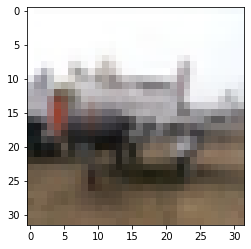

In [14]:
show_example(*dataset[1000])

Label:  deer (4)


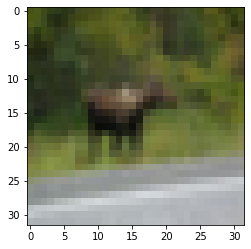

In [33]:
show_example(*dataset[22357])

In [16]:
random_seed = 42
torch.manual_seed(random_seed)

In [17]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [18]:
from torch.utils.data.dataloader import DataLoader

batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size, num_workers=4, pin_memory=True)

In [19]:
from torchvision.utils import make_grid

def showbatch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12,6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
        break

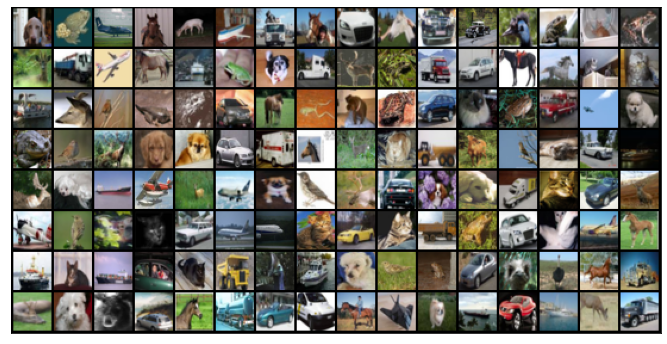

In [20]:
showbatch(train_dl)

In [21]:
def apply_kernel(image, kernel):
    ri, ci = image.shape
    rk, ck = kernel.shape
    ro, co = ri-rk+1, ci-ck+1
    output = torch.zeros([ro, co])
    for i in range(ro):
        for j in range(co):
            output[i,j] = torch.sum(image[i:i+rk, j:j+ck] * kernel)
    return output

In [22]:
sample_image = torch.tensor([
    [3, 3, 2, 1, 0], 
    [0, 0, 1, 3, 1], 
    [3, 1, 2, 2, 3], 
    [2, 0, 0, 2, 2], 
    [2, 0, 0, 0, 1]
], dtype=torch.float32)

sample_kernel = torch.tensor([
    [0, 1, 2], 
    [2, 2, 0], 
    [0, 1, 2]
], dtype=torch.float32)

apply_kernel(sample_image, sample_kernel)

tensor([[12., 12., 17.],
        [10., 17., 19.],
        [ 9.,  6., 14.]])

In [23]:
import torch.nn as nn
import torch.nn.functional as F

In [24]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [25]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 8, 16, 16])


In [26]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self.forward(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['train_loss'], result['val_loss'], result['val_acc']))

def accuracy(out, labels):
    _, preds = torch.max(out, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


In [27]:
class Cifar10CnnModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4

            nn.Flatten(), 
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10))
        
    def forward(self, xb):
        return self.network(xb)

In [28]:
model = Cifar10CnnModel()
print(model)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [29]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = model.forward(images)
    print('out.shape:', out.shape)
    print('out[0]', out[0])
    break

images.shape: torch.Size([128, 3, 32, 32])
out.shape: torch.Size([128, 10])
out[0] tensor([ 0.0227,  0.0050,  0.0075, -0.0167,  0.0360, -0.0371, -0.0080, -0.0307,
        -0.0291,  0.0121], grad_fn=<SelectBackward>)


In [30]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [31]:
device = get_default_device()
device

device(type='cuda')

In [32]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

Cifar10CnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=4096, out_features=1024, bias=True)
    (17): ReLU()
    (18): Linear(in_feat

In [34]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [33]:
model = to_device(Cifar10CnnModel(), device)

In [34]:
evaluate(model, val_dl)

{'val_loss': 2.3033015727996826, 'val_acc': 0.09902343899011612}

In [36]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = .001

In [39]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 1.7247, val_loss: 1.4002, val_acc: 0.4773
Epoch [1], train_loss: 1.2252, val_loss: 1.0793, val_acc: 0.6115
Epoch [2], train_loss: 0.9906, val_loss: 0.9160, val_acc: 0.6689
Epoch [3], train_loss: 0.8222, val_loss: 0.8319, val_acc: 0.7143
Epoch [4], train_loss: 0.7103, val_loss: 0.7495, val_acc: 0.7328
Epoch [5], train_loss: 0.5909, val_loss: 0.7180, val_acc: 0.7486
Epoch [6], train_loss: 0.5120, val_loss: 0.7254, val_acc: 0.7654
Epoch [7], train_loss: 0.4306, val_loss: 0.6954, val_acc: 0.7764
Epoch [8], train_loss: 0.3657, val_loss: 0.7036, val_acc: 0.7807
Epoch [9], train_loss: 0.3018, val_loss: 0.7458, val_acc: 0.7771


In [35]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs')

In [36]:
plot_accuracies(history)

NameError: name 'history' is not defined

In [37]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

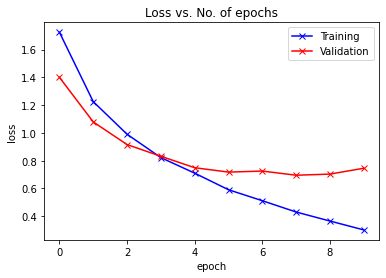

In [43]:
plot_losses(history)

In [38]:
test_dataset = ImageFolder(data_dir+'/test', transform=ToTensor())

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: dog , Predicted: deer


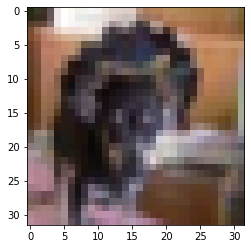

In [43]:
img, label = test_dataset[5468]
plt.imshow(img.permute(1,2,0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: automobile , Predicted: deer


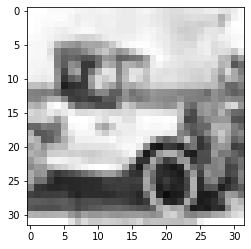

In [44]:
img, label = test_dataset[1002]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: frog , Predicted: deer


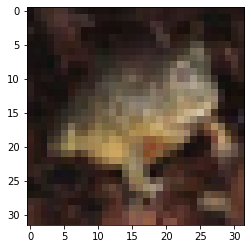

In [45]:
img, label = test_dataset[6153]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [49]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_loss': 2.3024709224700928, 'val_acc': 0.09765625}

In [53]:
torch.save(model.state_dict(), 'cifar10-cnn.pth')

In [46]:
model2 = to_device(Cifar10CnnModel(), device)

In [47]:
model2.load_state_dict(torch.load('cifar10-cnn.pth'))

<All keys matched successfully>

In [50]:
evaluate(model2, test_loader)

{'val_loss': 0.7658206820487976, 'val_acc': 0.775097668170929}

Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: deer
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: ship , Predicted: ship
Label: shi

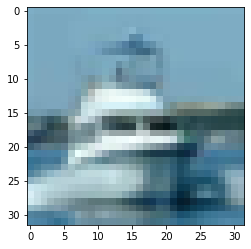

In [65]:
for i in range(200):
    img, label = test_dataset[8000 + i]
    print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model2))